In [22]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Import Python packages

In [23]:
from collections import OrderedDict
import torch
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
import random
import json
from optimizer.optimizer import BasePSOptimizer
import os

import configs
import utils
from generator.dataset import DataFolder
from optimizer.MOFinference import InferenceModel
from IPython.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))

Load Config and Data

In [24]:
config = configs.get_config()
utils.set_seed(config['generator_rand_seed'])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_dataset = DataFolder(config['tensors_train_prop'], config['train_batch_size'])
test_dataset = DataFolder(config['tensors_test_prop'], config['train_batch_size'])

Load Model

In [25]:
inference_model = InferenceModel(config)
model = inference_model.model
model_y = inference_model.model_y
torch.set_grad_enabled(False)

In [26]:
pcn_700 = [('None', 'sym_8_mc_9', 'bcu', 'Cc1cc([Lr])ccc1c2c(C)cc([Lr])cc2')]
irmof_1 = [('None', 'sym_6_mc_3', 'pcu', '[Lr]c1ccc(cc1)[Lr]')]
pcn_700_tensor = inference_model.mof_building_to_mof_tensor(pcn_700)
pcn_700_z = inference_model.mof_tensor_to_mof_z(pcn_700_tensor)
irmof_1_tensor = inference_model.mof_building_to_mof_tensor(irmof_1)
irmof_1_z = inference_model.mof_tensor_to_mof_z(irmof_1_tensor)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "D:\env\miniconda\envs\MGHVAE1\lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\GDP\AppData\Local\Temp\ipykernel_32408\103365441.py", line 3, in <module>
    pcn_700_tensor = inference_model.mof_building_to_mof_tensor(pcn_700)
  File "D:\code\python\code\MGHVAE\optimizer\MOFinference.py", line 34, in mof_building_to_mof_tensor
    df_mof_building = pd.DataFrame(mof_building,
  File "D:\env\miniconda\envs\MGHVAE1\lib\site-packages\pandas\core\frame.py", line 582, in __init__
    col2    int8
  File "D:\env\miniconda\envs\MGHVAE1\lib\site-packages\pandas\core\internals\construction.py", line 95, in arrays_to_mgr
  File "D:\env\miniconda\envs\MGHVAE1\lib\site-packages\pandas\core\internals\managers.py", line 1701, in create_block_manager_from_arrays
    pass
  File "D:\env\miniconda\envs\MGHVAE1\lib\site-packages\pandas\core\internals\managers.py", li

Neighboring Space Sampling

In [15]:
mof_df = pd.DataFrame([('None', 'sym_8_mc_9', 'bcu', 'Cc1cc([Lr])ccc1c2c(C)cc([Lr])cc2', 0.0)], 
                      columns=['organic_core', 'metal_node', 'topology', 'branch_smiles', 'dist'])
i = 0
tries = 100
noise_max = 20
while i < tries:
    sample = []
    noise = random.uniform(0, noise_max)
    sample_z = utils.perturb_z(pcn_700_z.cpu(), noise)
    try:
        outs = inference_model.mof_z_to_mof_building(sample_z)
        smiles = outs[0][3]
        if utils.capacity_score_smiles(smiles):
            dist = np.linalg.norm(pcn_700_z.cpu() - sample_z)
            sample_df = pd.DataFrame([(outs[0][0], outs[0][1], outs[0][2], smiles, dist)],
                                        columns=['organic_core', 'metal_node', 'topology', 'branch_smiles', 'dist'])
            mof_df = pd.concat([mof_df, sample_df], axis=0)
            i = i + 1
    except:
        pass
mof_df = mof_df.sort_values(by=['dist']).reset_index(drop=True)
display(mof_df)

organic_core  metal_node topology  \
0             None  sym_8_mc_9      bcu   
1             None  sym_8_mc_9      bcu   
2             None  sym_8_mc_9      bcu   
3             None  sym_8_mc_9      bcu   
4             None  sym_8_mc_9      bcu   
..             ...         ...      ...   
96   sym_3_vae_337  sym_3_mc_0     srsb   
97            None  sym_7_mc_4      nia   
98   sym_5_vae_218  sym_5_mc_2      ssb   
99     sym_5_on_10  sym_5_mc_2     rhrb   
100  sym_4_vae_107  sym_4_mc_1     diab   

                                 branch_smiles       dist  
0             Cc1cc([Lr])ccc1c2c(C)cc([Lr])cc2   0.000000  
1           Cc1cc([Lr])ccc1-c1c(C)cc([Lr])cc1C   0.053042  
2           Cc1cc([Lr])ccc1-c1c(C)cc([Lr])cc1C   0.081852  
3           Cc1cc([Lr])ccc1-c1c(C)cc([Lr])cc1C   0.097639  
4           Cc1cc([Lr])ccc1-c1c(C)cc([Lr])cc1C   0.125316  
..                                         ...        ...  
96   CSCc1cc([Lr])c(O)cc1C#Cc1c(O)cc([Lr])cc1S  14.179162  
97              Nc1cc([Lr])cc([Lr])c1C(=O)OC=O  14.717999  
98     CCCc1c(C#C[Lr])ccc(CC(C#C[Lr])CCC)c1CCC  15.274826  
99      CCc1cc2cc3c([Lr])cccc3c(C)c2c([Lr])c1S  16.370382  
100          Cc1cccc([Lr])c1C(N)([Lr])c1ccccc1  16.693913  

[101 rows x 5 columns]

Interpolation Sampling

In [16]:
num_points = 20
chunks = torch.stack([
    torch.linspace(irmof_1_z[i, j], pcn_700_z[i, j], steps=num_points)
    for i in range(irmof_1_z.shape[0])
    for j in range(irmof_1_z.shape[1])
], dim=1).view(num_points, *irmof_1_z.shape)
mof_chunks = []
for chunk in chunks:
    outs = inference_model.mof_z_to_mof_building(chunk)
    mof_chunks.append(outs[0])
mof_df = pd.DataFrame(mof_chunks, columns=['organic_core', 'metal_node', 'topology', 'branch_smiles'])
display(mof_df)

organic_core  metal_node topology                       branch_smiles
0              None  sym_6_mc_3      pcu                  [Lr]c1ccc([Lr])cc1
1              None  sym_6_mc_3      pcu                  [Lr]c1ccc([Lr])cc1
2     sym_3_vae_561  sym_6_mc_3      pcu                  [Lr]c1ccc([Lr])cc1
3     sym_3_vae_561  sym_8_mc_8      pcu                  [Lr]c1ccc([Lr])cc1
4     sym_3_vae_561  sym_8_mc_8      the                  [Lr]c1ccc([Lr])cc1
5     sym_3_vae_561  sym_8_mc_8      the                  [Lr]c1ccc([Lr])cc1
6     sym_3_vae_561  sym_8_mc_8      the                  [Lr]c1ccc([Lr])cc1
7     sym_3_vae_561  sym_3_mc_0     srsb                  [Lr]c1ccc([Lr])cc1
8     sym_3_vae_561  sym_3_mc_0     srsb                  [Lr]c1ccc([Lr])cc1
9     sym_3_vae_561  sym_5_mc_2      pto      Cc1cc([Lr])ccc1-c1ccc([Lr])cc1
10  sym_3_vae_BR429  sym_5_mc_2      pto      Cc1cc([Lr])ccc1-c1ccc([Lr])cc1
11       sym_4_on_6  sym_5_mc_2      pth      Cc1cc([Lr])ccc1-c1ccc([Lr])cc1
12       sym_4_on_6  sym_5_mc_2      pth      Cc1cc([Lr])ccc1-c1ccc([Lr])cc1
13       sym_4_on_6  sym_5_mc_2      pth      Cc1cc([Lr])ccc1-c1ccc([Lr])cc1
14       sym_4_on_6  sym_5_mc_2      pts      Cc1cc([Lr])ccc1-c1ccc([Lr])cc1
15       sym_4_on_6  sym_5_mc_2      pts     Cc1cc([Lr])ccc1-c1ccc([Lr])cc1C
16       sym_4_on_6  sym_8_mc_8      pts  Cc1cc([Lr])ccc1-c1c(C)cc([Lr])cc1C
17             None  sym_8_mc_8      bcu  Cc1cc([Lr])ccc1-c1c(C)cc([Lr])cc1C
18             None  sym_8_mc_9      bcu  Cc1cc([Lr])ccc1-c1c(C)cc([Lr])cc1C
19             None  sym_8_mc_9      bcu  Cc1cc([Lr])ccc1-c1c(C)cc([Lr])cc1C

PCA

In [17]:
img_title = ['PLD', 'LCD', 'density', 'AGSA', 'CO₂ uptake in CO₂/N₂',
            'N₂ uptake in CO₂/N₂', 'CO₂ uptake in CO₂/CH₄', 'CH₄ uptake in CO₂/CH₄']
y = []
z = []
for batch in tqdm(train_dataset):
    root_vecs, _, mol_batch = utils.get_vecs(model, batch, device)
    y.extend(model_y.scaler.inverse_transform(mol_batch['y'].cpu().numpy()))
    z.extend(root_vecs.cpu().numpy())
y = np.stack(y)
z = torch.tensor(np.stack(z))

  0%|          | 0/1000 [00:00<?, ?it/s]

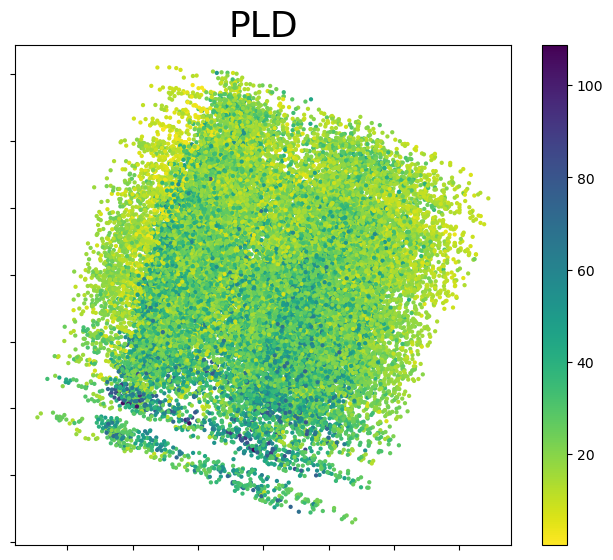

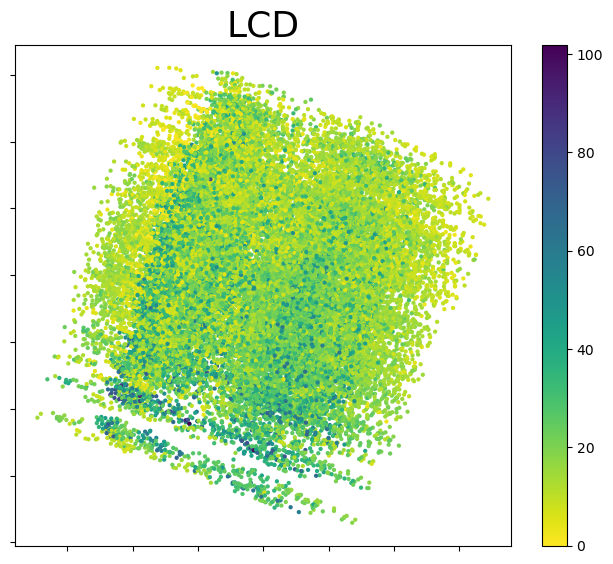

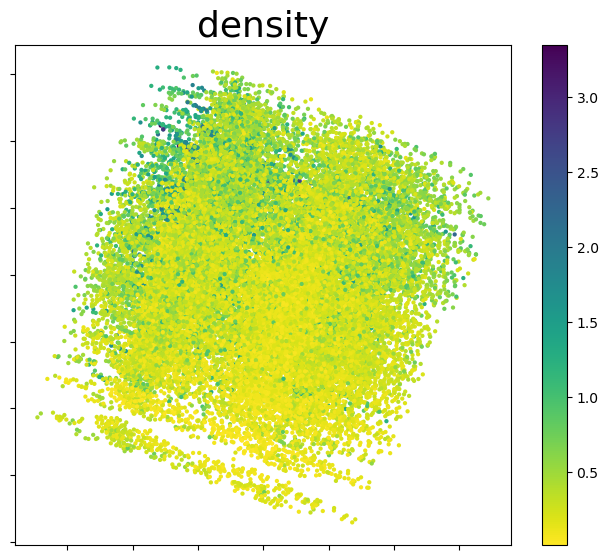

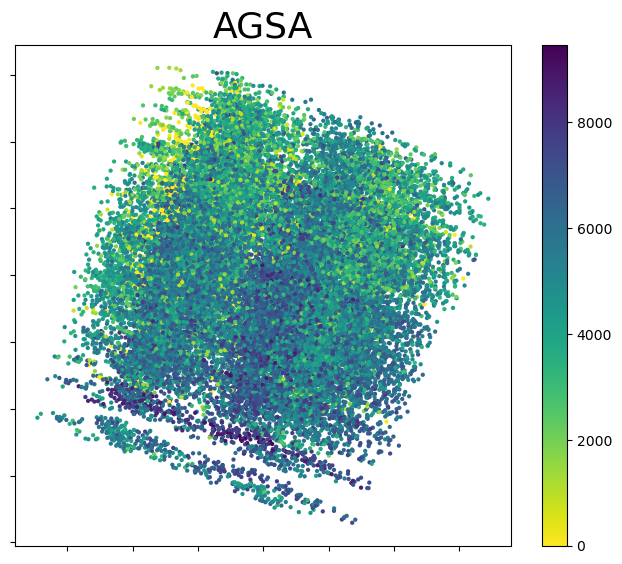

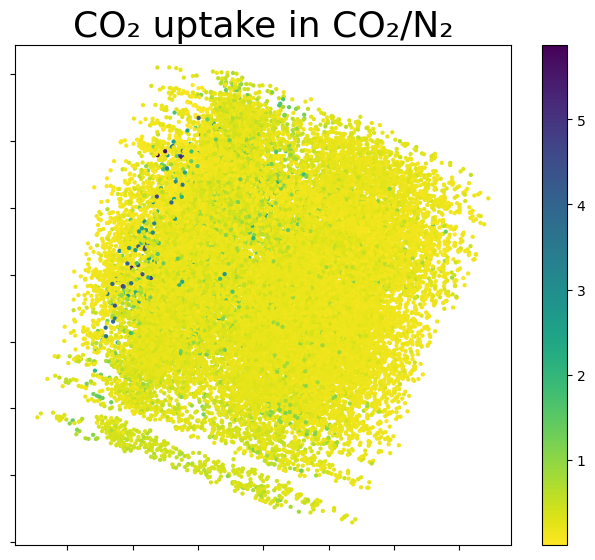

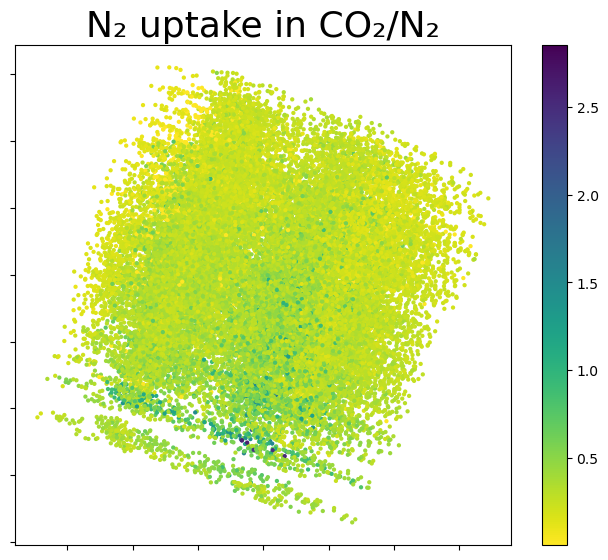

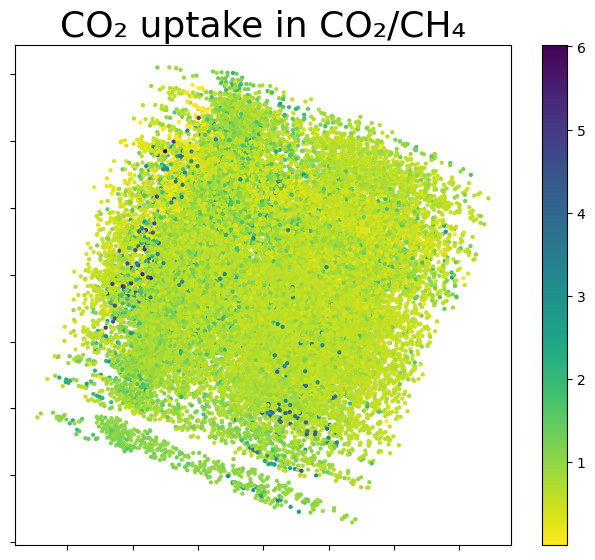

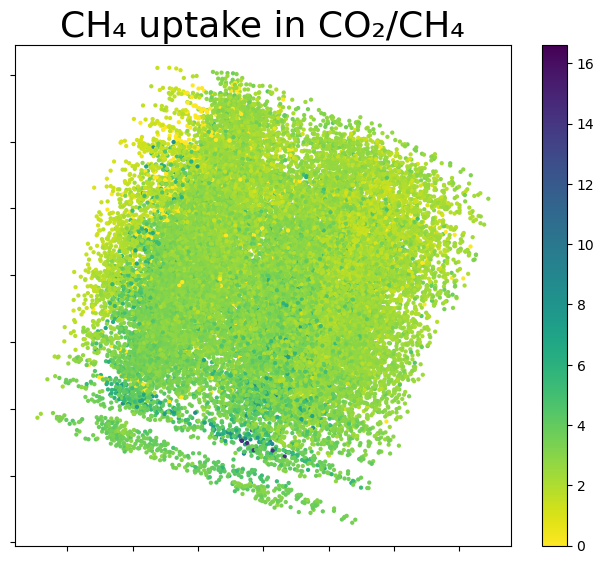

In [19]:
# U, S, V = torch.pca_lowrank(z,  q=2)
# data_pca = torch.matmul(z.cpu(), V)
z_centered = z - z.mean(dim=0)
U, S, V = torch.svd(z_centered)
V_q = V[:, :2]
data_pca = torch.mm(z_centered, V_q)
for index, y_label in enumerate(img_title):
    utils.pca_image(data_pca, y, index, y_label)

R2 of the Validation Set

In [20]:
y_true = OrderedDict()
y_pred = OrderedDict()
for i in range(len(config['col_y'])):
    y_true[i] = []
    y_pred[i] = []
for batch in tqdm(test_dataset):
    root_vecs, tree_vecs, mol_batch = utils.get_vecs(model, batch, device)
    outputs = model_y.z_to_y(root_vecs, tree_vecs)
    y_true_scaler = model_y.scaler.inverse_transform(mol_batch['y'].cpu().numpy())
    for i in range(len(config['col_y'])):
        y_true[i].extend(y_true_scaler[:, i].reshape(-1))
        y_pred[i].extend(outputs[:, i].reshape(-1))
r2_results = utils.regression_statistics(y_true, y_pred, config['col_y'])

  0%|          | 0/1000 [00:00<?, ?it/s]

lcd : R2 =  0.9145126160521148 , MAE =  2.447661789010149 , RMSE =  3.9200369575599323
pld : R2 =  0.9121897358076136 , MAE =  2.1324761551161187 , RMSE =  3.6198886505421735
density : R2 =  0.9159124148915394 , MAE =  0.04409843944026082 , RMSE =  0.08175608049193973
agsa : R2 =  0.9198647910973381 , MAE =  334.52230050854996 , RMSE =  502.06124313068625
co2n2_co2_mol_kg : R2 =  0.8025713994453918 , MAE =  0.045598752145698904 , RMSE =  0.11372730168171848
co2n2_n2_mol_kg : R2 =  0.9196824710803562 , MAE =  0.027298270924654606 , RMSE =  0.044510895568313585
co2ch4_co2_mol_kg : R2 =  0.8706533611287328 , MAE =  0.07710737984384278 , RMSE =  0.15796755360213538
co2ch4_ch4_mol_kg : R2 =  0.859871776662803 , MAE =  0.21346916221208068 , RMSE =  0.3461621849384396


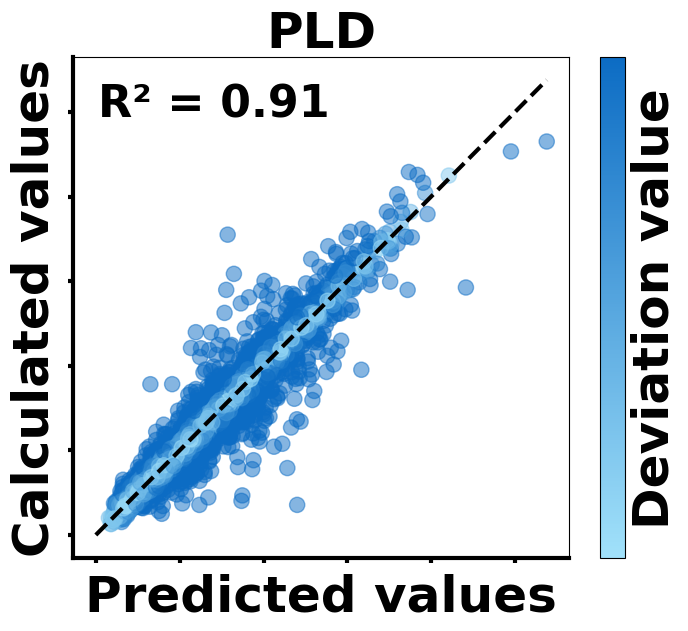

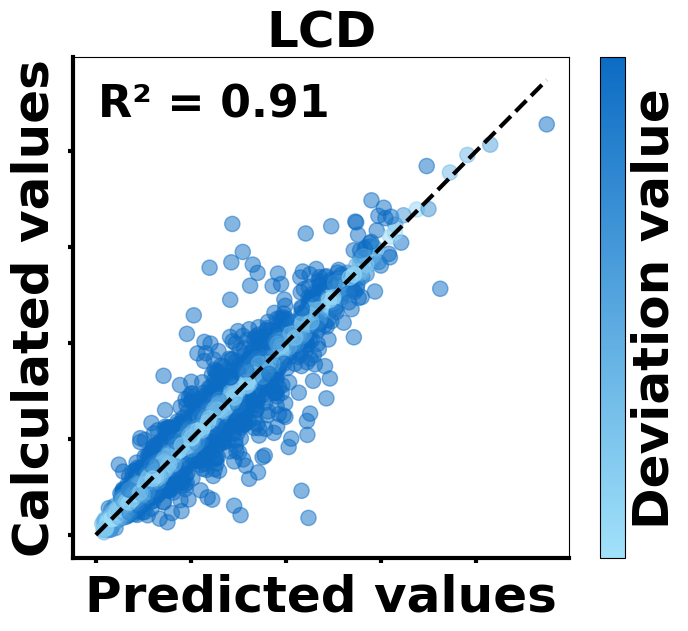

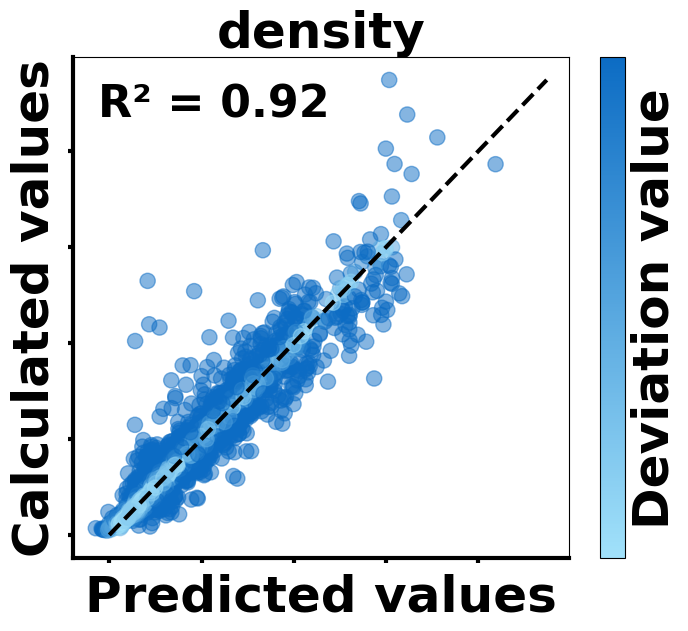

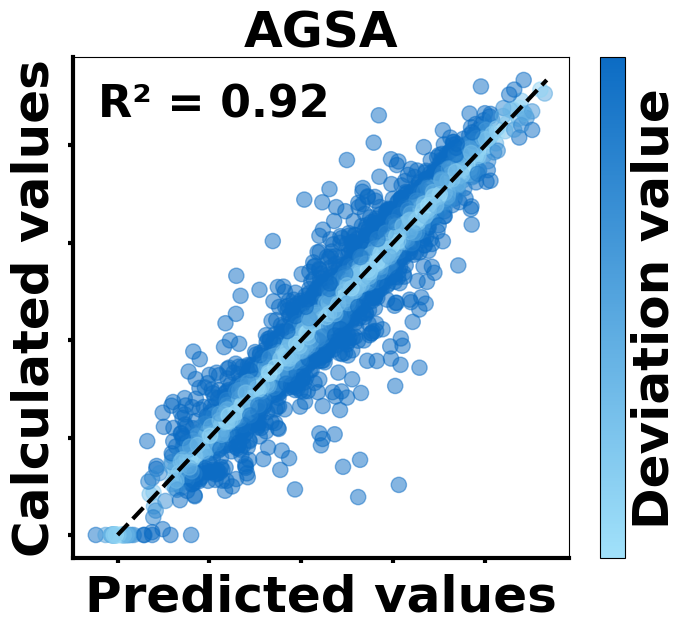

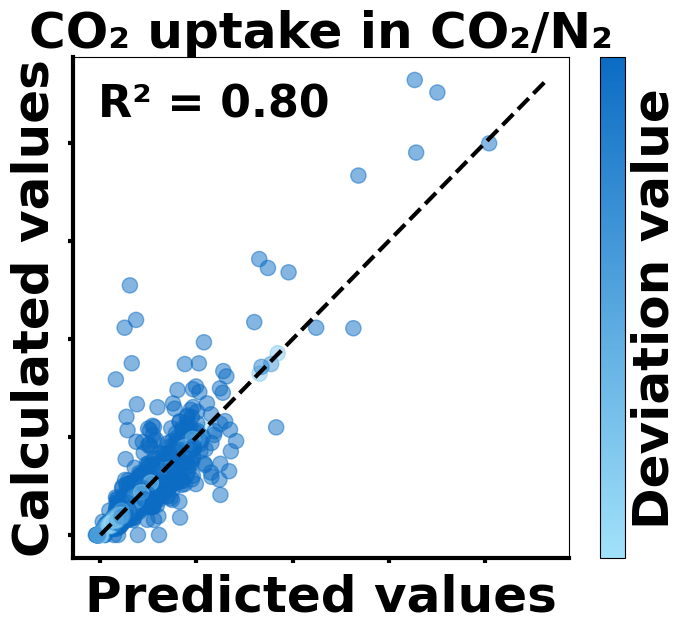

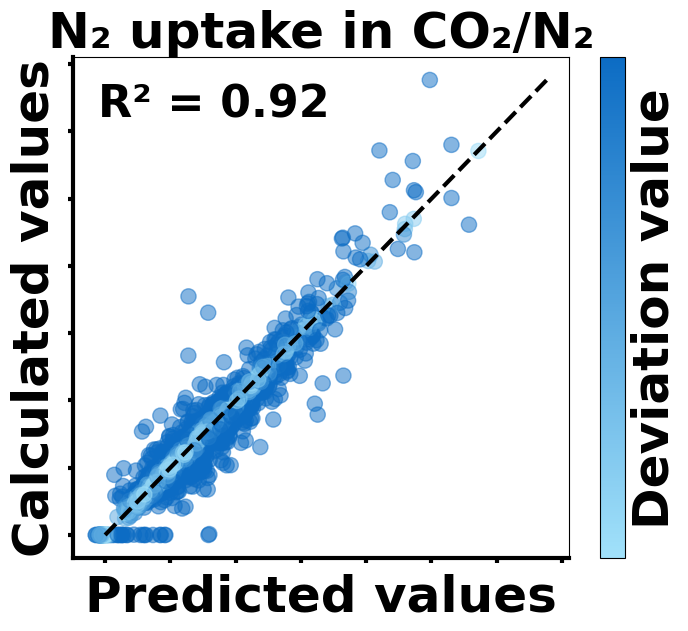

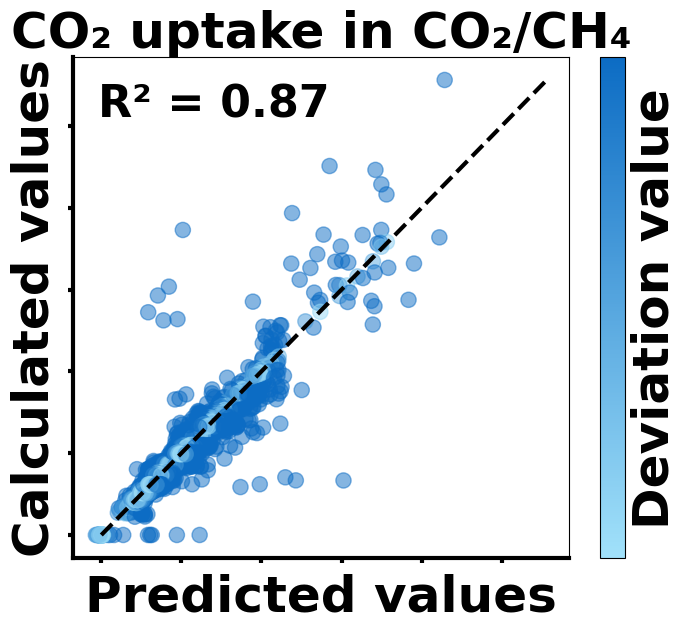

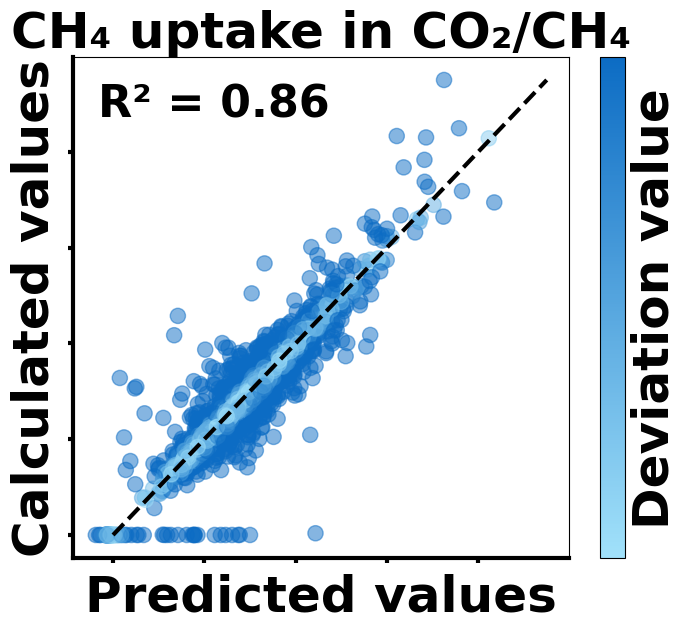

In [21]:
for index, r2_title_value in enumerate(img_title):
    r2 = r2_results['R2'][index]
    y_true_values = y_true[index]
    y_pred_values = y_pred[index]
    plt = utils.plot_scatter_with_deviation(y_true_values, y_pred_values, r2, r2_title_value)
    plt.show()

Find Candidates

In [22]:
start_mof = [('None', 'sym_6_mc_3', 'pcu', '[Lr]c1ccc(cc1)[Lr]')]

if not os.path.exists(config['x_max']) or not config['x_min']:
    model = inference_model.model
    train_dataset = DataFolder(config['tensors_train_prop'], config['train_batch_size'])
    z = []
    x_max = []
    x_min = []
    with torch.no_grad():
        for batch in tqdm(train_dataset):
            root_vecs, _, _ = utils.get_vecs(model, batch, device)
            z.extend(root_vecs.cpu().numpy())
    z = np.stack(z)
    for index in range(z.shape[1]):
        x_max.append(np.max(z[:, index]))
        x_min.append(np.min(z[:, index]))
    np.save(config['x_max'], x_max)
    np.save(config['x_min'], x_min)
else:
    x_max = np.load(config['x_max'])
    x_min = np.load(config['x_min'])

opt_config_dict = dict(configs.opt_config())
print("optimizer config: ")
print(json.dumps(opt_config_dict, indent=4))

optimizer config: 
{
    "opt_num_part": 10,
    "opt_num_swarms": 1,
    "opt_iterations_num": 50,
    "opt_num_track": 20,
    "opt_fitness_name": "co2n2_co2_mol_kg",
    "opt_col": [
        "fitness",
        "branch_smiles",
        "metal_node",
        "organic_core",
        "topology",
        "lcd",
        "pld",
        "density",
        "agsa",
        "co2n2_co2_mol_kg",
        "co2n2_n2_mol_kg",
        "co2ch4_co2_mol_kg",
        "co2ch4_ch4_mol_kg"
    ],
    "x_min": "results/z_max_min/x_min.npy",
    "x_max": "results/z_max_min/x_max.npy",
    "v_min": -0.4,
    "v_max": 0.4
}


In [26]:
opt = BasePSOptimizer.from_query(
        init_building_list=start_mof,
        num_part=config['opt_num_part'],
        num_swarms=config['opt_num_swarms'],
        inference_model=inference_model,
        fitness_name=config['opt_fitness_name'],
        opt_col=config['opt_col'],
        x_min=x_min,
        x_max=x_max,
        v_min=config['v_min'],
        v_max=config['v_max'],
)
opt.run(config['opt_iterations_num'], num_track=config['opt_num_track'])
display(opt.step_fitness_history)

step  max_fitness  min_fitness  mean_fitness
0     0     0.500722     0.500722      0.500722
0     1     0.500722     0.442030      0.473074
0     2     0.571062     0.500722      0.506351
0     3     0.826535     0.500722      0.531885
0     4     0.826535     0.500722      0.531885
0     5     0.826535     0.500722      0.531885
0     6     0.826535     0.500722      0.533554
0     7     1.413071     0.500722      0.579864
0     8     1.413071     0.500722      0.647928
0     9     1.413071     0.500722      0.647928
0    10     1.413071     0.500722      0.694087
0    11     1.413071     0.500722      0.694087
0    12     1.413071     0.500722      0.694087
0    13     1.413071     0.500722      0.703299
0    14     1.413071     0.500722      0.703299
0    15     1.413071     0.500722      0.703299
0    16     1.413071     0.500722      0.703299
0    17     1.413071     0.500722      0.703299
0    18     1.413071     0.500722      0.703299
0    19     1.413071     0.500722      0.703299
0    20     1.413071     0.500722      0.703299
0    21     1.413071     0.500722      0.703299
0    22     1.413071     0.500722      0.703299
0    23     1.413071     0.500722      0.703299
0    24     1.413071     0.500722      0.703299
0    25     1.413071     0.500722      0.709254
0    26     1.413071     0.500722      0.709254
0    27     1.413071     0.500722      0.710375
0    28     1.413071     0.500722      0.710375
0    29     1.413071     0.500722      0.710375
0    30     1.413071     0.500722      0.710375
0    31     1.413071     0.500722      0.721451
0    32     1.413071     0.514585      0.755432
0    33     1.413071     0.517405      0.756227
0    34     1.413071     0.517405      0.756227
0    35     1.413071     0.542917      0.786381
0    36     1.413071     0.542917      0.786381
0    37     1.413071     0.542917      0.786381
0    38     1.413071     0.542917      0.786381
0    39     1.413071     0.542959      0.796020
0    40     1.413071     0.571062      0.831243
0    41     1.413071     0.571062      0.831243
0    42     1.413071     0.571062      0.831243
0    43     1.413071     0.593774      0.838816
0    44     1.413071     0.625792      0.878614
0    45     1.413071     0.684973      0.886772
0    46     1.413071     0.685598      0.890818
0    47     1.413071     0.685598      0.890818
0    48     1.413071     0.697709      0.899334
0    49     1.413071     0.722244      0.920489

In [16]:
display(opt.best_step_mof_history)

fitness   organic_core    metal_node topology  \
0   0.310952           None    sym_6_mc_3      pcu   
1   0.310951           None    sym_6_mc_3      pcu   
2   1.208078           None    sym_6_mc_3      bcs   
3   1.445133           None    sym_6_mc_3      bcs   
4   1.351023           None    sym_6_mc_3      bcs   
5   3.321774    sym_16_mc_6    sym_6_mc_3      bcs   
6   2.749573    sym_16_mc_6    sym_6_mc_3      bcs   
7   0.899782           None    sym_6_mc_3      bcs   
8   2.473598    sym_16_mc_6    sym_6_mc_3      bcs   
9   0.251554           None    sym_6_mc_3      bcs   
10  1.369343    sym_16_mc_6    sym_4_mc_1      bcs   
11  2.211138    sym_16_mc_6    sym_6_mc_3      bcs   
12  0.270383           None    sym_6_mc_3      bcs   
13  0.425402    sym_16_mc_6    sym_4_mc_1      bcs   
14  0.252268  sym_3_vae_456  sym_24_mc_13      rht   
15  0.206806           None  sym_24_mc_13      bcs   
16  0.206012           None  sym_24_mc_13      rht   
17  0.264992  sym_3_vae_724    sym_4_mc_1      bcs   
18  2.664447    sym_16_mc_6    sym_4_mc_1      bcs   
19  0.139857           None  sym_24_mc_13      bcs   
20  0.697438    sym_16_mc_6    sym_4_mc_1      bcs   

                                        branch_smiles        lcd        pld  \
0                                  [Lr]c1ccc(cc1)[Lr]  10.359832   6.173549   
1                                  [Lr]c1ccc([Lr])cc1  10.359832   6.173549   
2                                  [Lr]c1ccc([Lr])cc1  10.471687   8.524778   
3                            [Lr]c1ccc([Lr])c2ccccc12   8.450154   7.559001   
4                   Cc1cc([Lr])ccc1-c1ccc([Lr])cc1C#N  12.195616   9.776231   
5             Cc1cc([Lr])ccc1-c1ccc([Lr])cc1-c1ccccc1  17.344393   7.215226   
6             Cc1cc([Lr])ccc1-c1ccc([Lr])cc1-c1ccccc1  17.260283   7.288726   
7                                  [Lr]c1ccc([Lr])cc1  10.478231   8.765443   
8             Cc1cc([Lr])ccc1-c1cc([Lr])ccc1-c1ccccc1  12.673195   6.394229   
9                   Cc1cc([Lr])ccc1-c1ccc([Lr])cc1C#N  14.963582  10.227584   
10                       Cc1cc([Lr])ccc1-c1ccccc1[Lr]   9.530438   4.044813   
11               Cc1cc2c([Lr])ccc(-c3ccccc3)c2cc1[Lr]  16.740540   7.198656   
12                  Cc1cc([Lr])ccc1-c1cc([Lr])ccc1C#N  17.911348  10.616760   
13     Cc1c([Lr])cccc1-c1ccc(C#N)c2c([Lr])ccc(C#N)c12  13.924994   7.082067   
14                                 [Lr]c1ccc([Lr])cc1  16.144651   9.910863   
15                     Cc1cc([Lr])ccc1-c1cccc([Lr])c1   9.786288  14.956272   
16                    Clc1ccc(-c2ccc([Lr])cc2)cc1[Lr]  24.550837  21.055870   
17                                Cc1cc([Lr])ccc1[Lr]  22.782045  12.614505   
18             Cc1cc([Lr])c2c([Lr])ccc(-c3ccccc3)c2c1  13.249734   5.828346   
19                           [Lr]c1ccc([Lr])c2ccccc12  10.298043   8.703586   
20  Cc1c(-c2cc([Lr])c(-c3ccccc3)cc2-c2ccccc2)ccc(-...  12.032903   3.244514   

     density         agsa  co2n2_co2_mol_kg  co2n2_n2_mol_kg  \
0   1.095152  1551.449097          0.310952         0.173894   
1   1.095152  1551.448853          0.310951         0.173894   
2   1.223590  1392.744995          1.208078         0.265212   
3   1.301433  1721.104126          1.445133         0.282501   
4   0.700640  3469.328369          1.351023         0.272349   
5   0.727849  2667.038330          3.321774         0.269863   
6   0.714599  2637.936279          2.749573         0.276306   
7   1.124984  2327.756104          0.899782         0.256401   
8   0.811850  1773.364380          2.473598         0.253195   
9   0.640348  3295.496338          0.251554         0.256815   
10  1.041409  1487.046265          1.369343         0.201284   
11  0.719380  2365.340820          2.211138         0.290496   
12  0.862227  3261.292969          0.270383         0.279034   
13  0.634857  2011.381470          0.425402         0.333076   
14  0.268409  6560.143555          0.252268         0.235600   
15  0.866823  2696.156250          0.206806         0